# Étude statistique sur la corrélation entre les données météorologiques et la consommation électrique en France en 2025

In [6]:
import numpy as np
import pandas as pd
import logging

from scrap import DataGouvFrScrapper

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
scrapper = DataGouvFrScrapper(
    dataset_id="6569b51ae64326786e4e8e1a",
    timeout=30,
    max_retries=4,
    sleep_between_retries=2.5,
    path="./data/meteofrance"
)

meteofrance_df = scrapper.build_dataframe(filter=lambda url: ("2025-2026" in url and "RR-T-Vent" in url) or ("RR-T-Vent" in url and "descriptif_champs" in url))

2026-01-21 12:33:02,488 - INFO - Fetching dataset infos from https://www.data.gouv.fr/api/1/datasets/6569b51ae64326786e4e8e1a/
2026-01-21 12:33:02,856 - INFO - Resource "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_24_1875-1949_RR-T-Vent.csv.gz" filtered out, skipping download.
2026-01-21 12:33:02,857 - INFO - Resource "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_24_1875-1949_autres-parametres.csv.gz" filtered out, skipping download.
2026-01-21 12:33:02,857 - INFO - File "./data/meteofrance/Q_descriptif_champs_RR-T-Vent.csv" already exists, skipping download.
2026-01-21 12:33:02,858 - INFO - Resource "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_descriptif_champs_autres-parametres.csv" filtered out, skipping download.
2026-01-21 12:33:02,859 - INFO - Resource "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_01_1852-1949_RR-T-Vent.csv.gz" filtered out, skipping download.

In [9]:
meteofrance_df.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,86009001,ARCHIGNY,46.685333,0.678833,138,20250101,0.0,1.0,-0.1,1.0,...,NaN,NaN,11.4,1.0,210.0,1.0,2355.0,9.0,NaN,NaN
1,86009001,ARCHIGNY,46.685333,0.678833,138,20250102,18.4,1.0,2.8,1.0,...,NaN,NaN,15.0,1.0,210.0,1.0,905.0,9.0,NaN,NaN
2,86009001,ARCHIGNY,46.685333,0.678833,138,20250103,0.0,1.0,0.6,1.0,...,NaN,NaN,7.7,1.0,90.0,1.0,1350.0,9.0,NaN,NaN
3,86009001,ARCHIGNY,46.685333,0.678833,138,20250104,8.0,1.0,-0.4,1.0,...,NaN,NaN,11.7,1.0,230.0,1.0,2027.0,9.0,NaN,NaN
4,86009001,ARCHIGNY,46.685333,0.678833,138,20250105,1.6,1.0,10.8,1.0,...,NaN,NaN,14.5,1.0,210.0,1.0,1215.0,9.0,NaN,NaN


On regroupe la table par jour

In [10]:
temperature_quotidienne = meteofrance_df.groupby("AAAAMMJJ")

In [11]:
temp_national_quotidienne = (
    meteofrance_df
    .assign(date=pd.to_datetime(meteofrance_df['AAAAMMJJ'].astype(str), format='%Y%m%d'))
    .groupby('date', sort=True)['TM']
    .mean()
    .reset_index(name='TM_mean')
)

,date,TM_mean
0,2025-01-01,6.949880
1,2025-01-02,7.480241
2,2025-01-03,5.100048
3,2025-01-04,5.656633
4,2025-01-05,11.368002
...,...,...
380,2026-01-16,9.952634
381,2026-01-17,9.618177
382,2026-01-18,9.239166
383,2026-01-19,8.520163


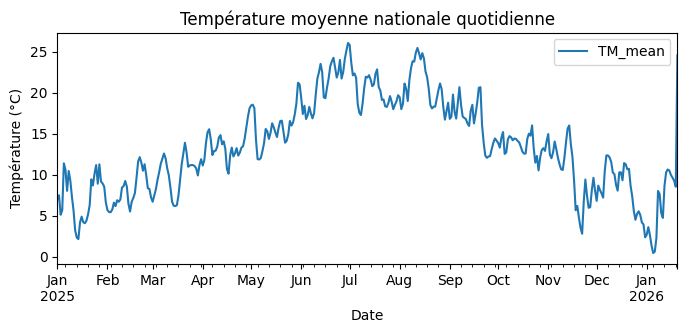

In [12]:
temp_national_quotidienne.plot(x='date', y='TM_mean', title='Température moyenne nationale quotidienne', ylabel='Température (°C)', xlabel='Date', figsize=(8, 3))
temp_national_quotidienne

<Axes: title={'center': 'Température moyenne nationale hebdomadaire'}, xlabel='Date', ylabel='Température (°C)'>

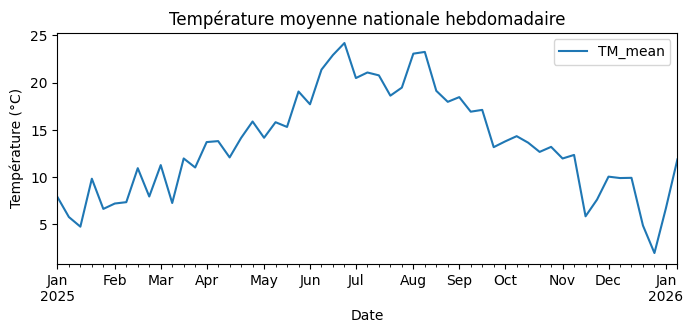

In [13]:
# calcul de la température moyenne tous les cinq jours
temp_national_hebdo = temp_national_quotidienne.set_index('date').resample('7D').mean().reset_index()
temp_national_hebdo.plot(x='date', y='TM_mean', title='Température moyenne nationale hebdomadaire', ylabel='Température (°C)', xlabel='Date', figsize=(8, 3))

In [14]:
# Charger le dataframe de consommation RTE en utilisant main.read_rte_file
from main import read_rte_file

rte_path = "./data/rte/conso_mix_RTE_2025.xls"
try:
    rte_df = read_rte_file(rte_path)
    print("RTE dataframe shape:", rte_df.shape)
except Exception as e:
    print("Could not read RTE file:", e)

RTE dataframe shape: (33847, 5)


In [15]:
display(rte_df.head())

,date,Heures,PrévisionJ-1,PrévisionJ,Consommation
0,2025-01-01,00:00,57711.0,63667.0,64354.0
1,2025-01-01,00:15,57122.0,64233.0,64521.0
2,2025-01-01,00:30,62700.0,63100.0,63715.0
3,2025-01-01,00:45,62700.0,63100.0,62502.0
4,2025-01-01,01:00,61100.0,61300.0,61490.0


In [16]:
# add a 1/consomamation collumn to rte_df
rte_df['1/Consommation'] = 1 / rte_df['Consommation']

<Axes: title={'center': 'inverse de la consommation moyenne nationale quotidienne'}, xlabel='Date', ylabel='inverse de la consommation'>

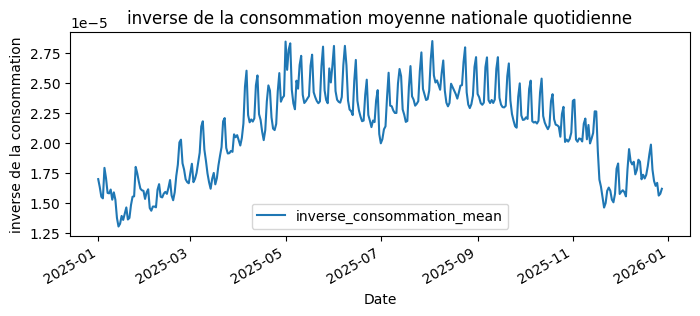

In [17]:
conso_national_quotidienne = (
    rte_df
    .assign(date=pd.to_datetime(rte_df['date'], format='%Y-%m-%d'))
    .groupby('date', sort=True)['1/Consommation']
    .mean()
    .reset_index(name='inverse_consommation_mean')
)

conso_national_quotidienne.plot(x='date', y='inverse_consommation_mean', title='inverse de la consommation moyenne nationale quotidienne', ylabel='inverse de la consommation', xlabel='Date', figsize=(8, 3))

<Axes: title={'center': 'inverse de la consommation moyenne nationale hebdomadaire'}, xlabel='Date', ylabel='inverse de la consommation'>

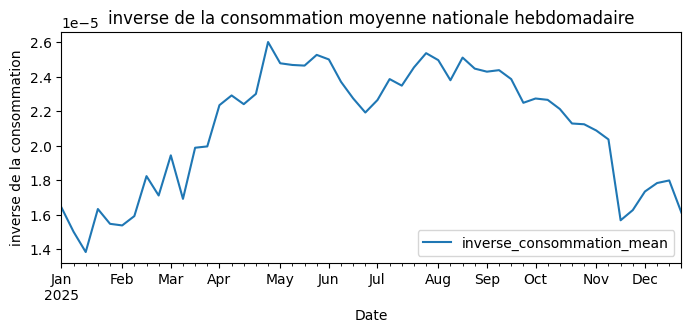

In [18]:
conso_national_hebdo = conso_national_quotidienne.set_index('date').resample('7D').mean().reset_index()
conso_national_hebdo.plot(x='date', y='inverse_consommation_mean', title='inverse de la consommation moyenne nationale hebdomadaire', ylabel='inverse de la consommation', xlabel='Date', figsize=(8, 3))

Nombre d observations : 55
D'Agostino K2 stat=2.8306, p-value=0.2429
Shapiro-Wilk stat=0.9778, p-value=0.4007


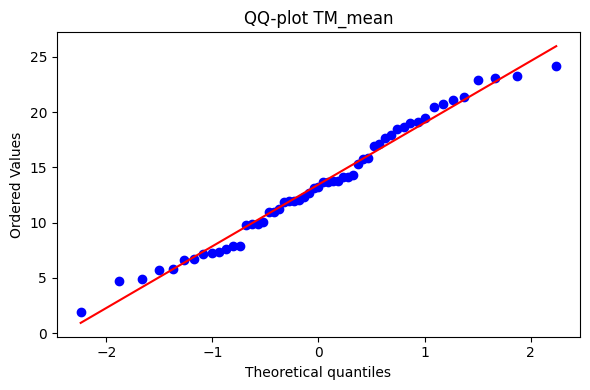

In [19]:
# Test de normalité sur la température moyenne nationale hebdomadaire
import scipy.stats as stats
import matplotlib.pyplot as plt

data = temp_national_hebdo['TM_mean'].dropna()
print('Nombre d observations :', len(data))

# D'Agostino K2 test
k2_stat, k2_p = stats.normaltest(data)
print(f"D'Agostino K2 stat={k2_stat:.4f}, p-value={k2_p:.4g}")

# Shapiro-Wilk
sh_stat, sh_p = stats.shapiro(data)
print(f"Shapiro-Wilk stat={sh_stat:.4f}, p-value={sh_p:.4g}")

# QQ-plot
plt.figure(figsize=(6,4))
stats.probplot(data, dist="norm", plot=plt)
plt.title("QQ-plot TM_mean")
plt.tight_layout()
plt.show()

## Test de corrélation entre la température réel et la consommation électrique

In [20]:
from scipy.stats import pearsonr, spearmanr, kendalltau

Corrélation de Pearson (corrélation linéaire)

In [22]:
x, y = temp_national_hebdo['TM_mean'], conso_national_hebdo['inverse_consommation_mean']
x.shape, y.shape

((55,), (52,))

In [25]:
x_clean, y_clean = x[:52], y[:]
x_clean.shape, y_clean.shape

((52,), (52,))

In [26]:
pearson_corr, pearson_p = pearsonr(x_clean, y_clean)
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4g}")

Pearson correlation: 0.8588, p-value: 3.873e-16


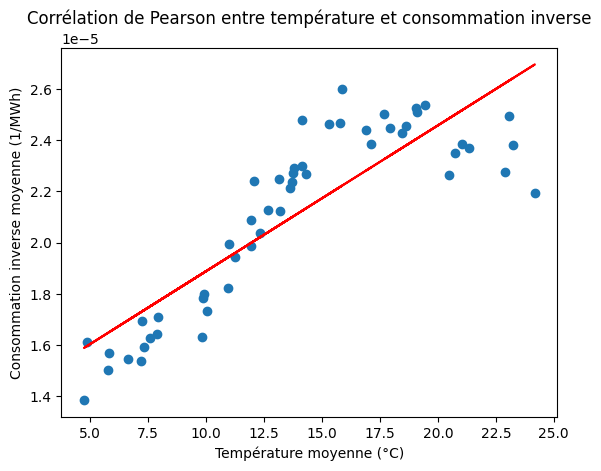

In [33]:
coef = np.polyfit(x_clean, y_clean, 1)
poly = np.poly1d(coef)

plt.figure()
plt.scatter(x_clean, y_clean)
plt.plot(x_clean, poly(x_clean), color='red')
plt.xlabel("Température moyenne (°C)")
plt.ylabel("Consommation inverse moyenne (1/MWh)")
plt.title("Corrélation de Pearson entre température et consommation inverse")
plt.show()

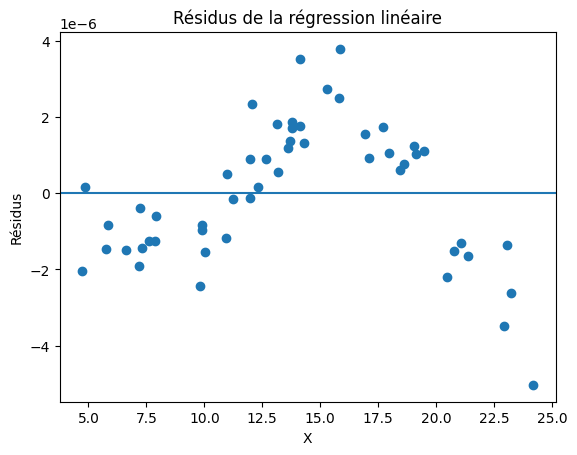

In [40]:
y_pred = poly(x_clean)
residuals = y_clean - y_pred

plt.figure()
plt.scatter(x_clean, residuals)
plt.axhline(0)
plt.xlabel("X")
plt.ylabel("Résidus")
plt.title("Résidus de la régression linéaire")
plt.show()

In [27]:
spearman_corr, spearman_p = spearmanr(x_clean, y_clean)
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4g}")

Spearman correlation: 0.8674, p-value: 8.973e-17


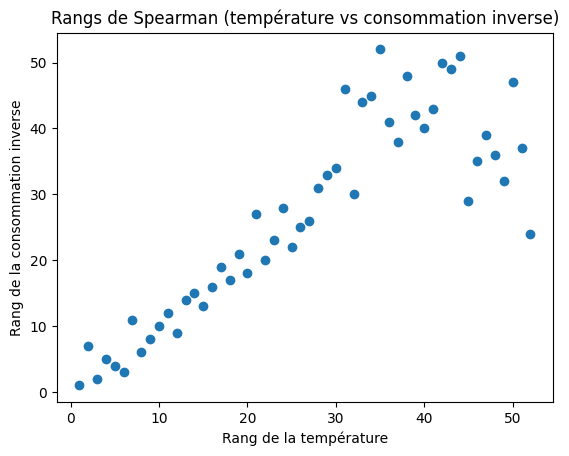

In [35]:
from scipy.stats import rankdata

x_rank = rankdata(x_clean)
y_rank = rankdata(y_clean)

plt.figure()
plt.scatter(x_rank, y_rank)
plt.xlabel("Rang de la température")
plt.ylabel("Rang de la consommation inverse")
plt.title("Rangs de Spearman (température vs consommation inverse)")
plt.show()

In [28]:
kendalltau_corr, kendalltau_p = kendalltau(x_clean, y_clean)
print(f"Kendall Tau correlation: {kendalltau_corr:.4f}, p-value: {kendalltau_p:.4g}")

Kendall Tau correlation: 0.7164, p-value: 6.553e-14


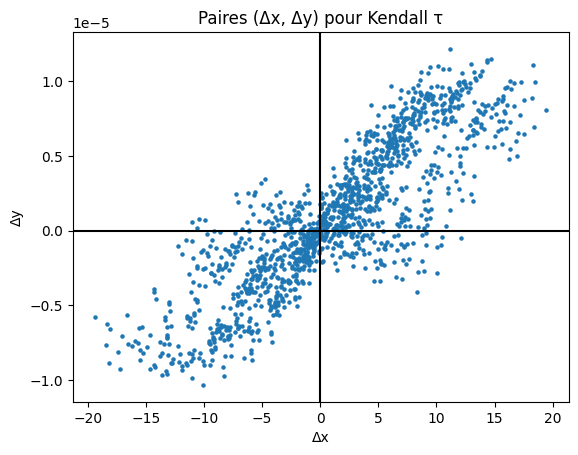

In [39]:
dx = []
dy = []

n = len(x_clean)
for i in range(n):
    for j in range(i+1, n):
        dx.append(x_clean[j] - x_clean[i])
        dy.append(y_clean[j] - y_clean[i])

dx = np.array(dx)
dy = np.array(dy)

plt.figure()
plt.scatter(dx, dy, s=5)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel("Δx")
plt.ylabel("Δy")
plt.title("Paires (Δx, Δy) pour Kendall τ")
plt.show()